In [2]:
import cv2
import numpy as np
from mask_grid_lines import mask_grid_lines
from slic import slic_rag
from extraction import extraction
import matplotlib.pyplot as plt


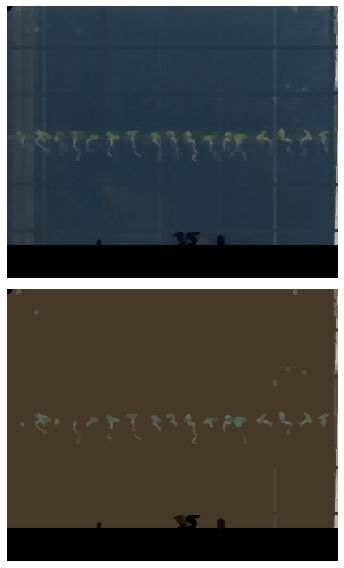

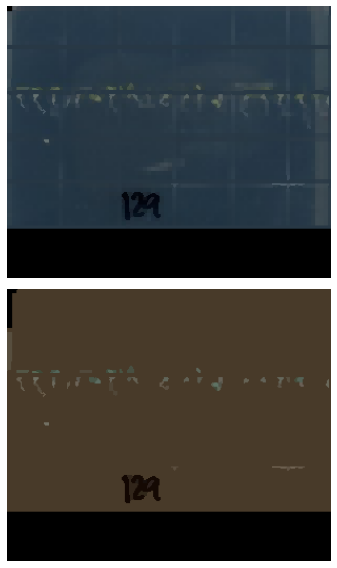

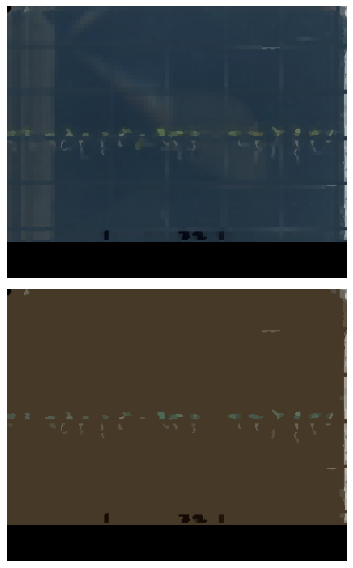

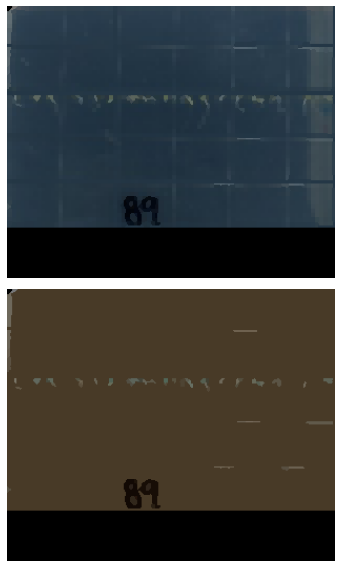

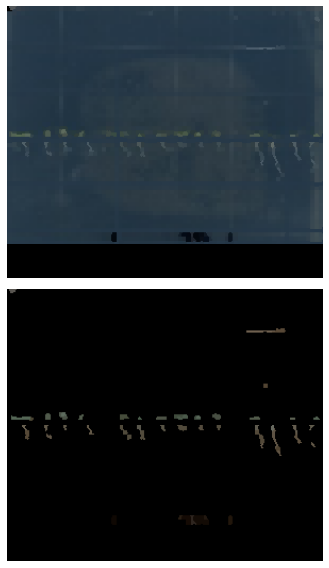

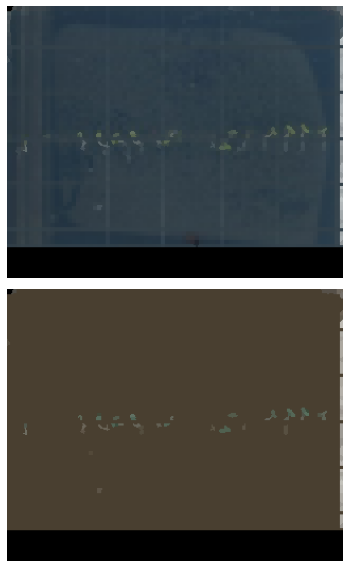

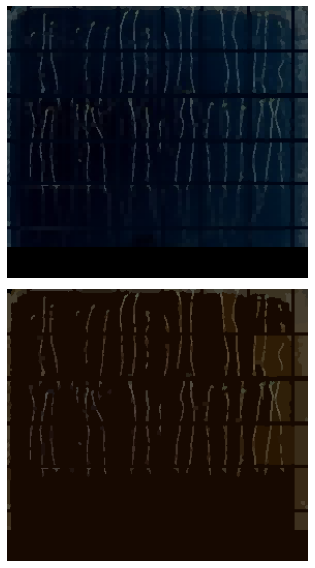

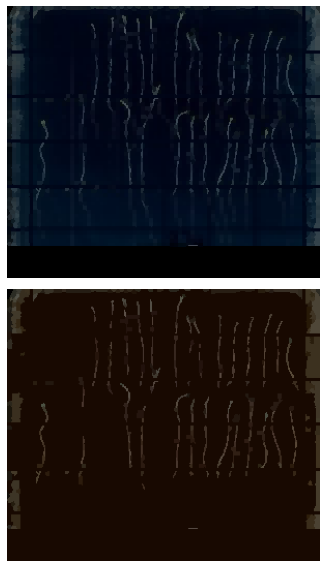

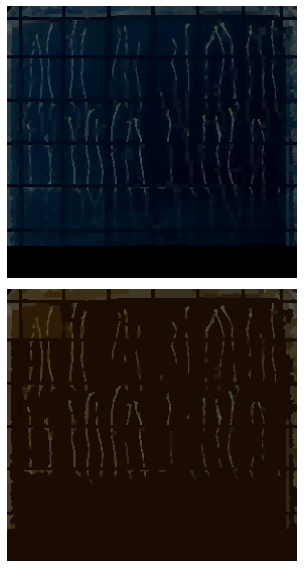

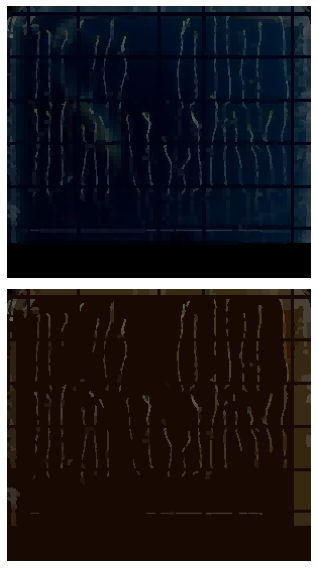

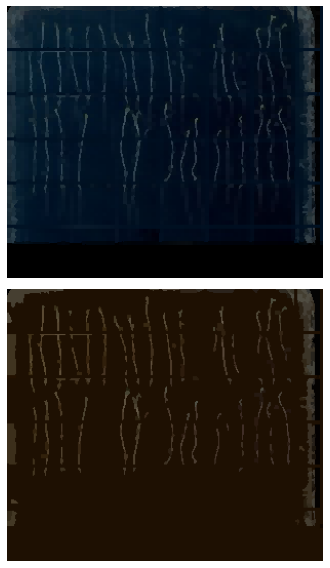

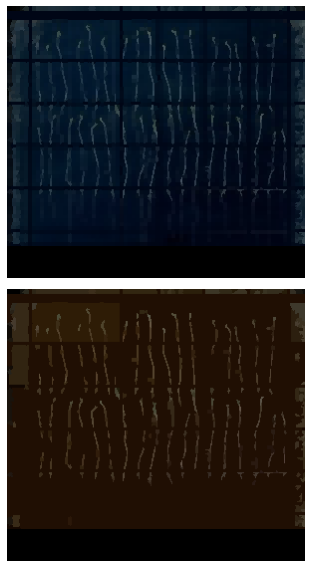

In [6]:
files=['2.jpg','1.jpg']
#Reading image files
for d in files:
    image_original=cv2.imread(d)
    # Converting RGB image to HSV color space
    image_hsv_original=cv2.cvtColor(image_original,cv2.COLOR_BGR2HSV)
    # Blurring image for better edge detection
    blur=cv2.medianBlur(image_hsv_original[:,:,1],9)
    # Binary thresholding the single channel image
    ret,image_result_original = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Defining the size and type of the structural element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    # Performing morphological opening to remove noise
    image_result_original = cv2.morphologyEx(image_result_original, cv2.MORPH_OPEN, kernel, )
    # Finding contours in the binary image
    contours= cv2.findContours(image_result_original, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    image_copy_original=image_original.copy()
    ROI=[]
    k=0
    final_image=np.zeros_like(image_original)
    #Traversing through the contours
    for c in contours:
        #Filtering contours by area 
        if(cv2.contourArea(c)>10000):
            #Finding 4-sided plates in the picture to process each separately
            approx = cv2.approxPolyDP(c,0.09 * cv2.arcLength(c, True), True) 
            if(len(approx)==4):  
                # For each square part of the image, we perform the following
                x,y,w,h = cv2.boundingRect(c)
                cv2.rectangle(image_copy_original, (x,y),(x+w,y+h), (255,0,0),10) 
                #Extract the square region from the full image
                ROI=image_original[y:y+h,x:x+w]
                coordinates=[(y,x),(y+h,x+w)]
                #Detecting the grid lines in the image and assign it the frequent pixel (background) in the picture
                masked_image=np.array(mask_grid_lines(image_original,coordinates))
                #Using SLIC algorithm and performing graph cuts on the color map
                segment_image=slic_rag(masked_image[y:y+h,x:x+w])
                # Extract the features and perform a couple of morphological operations for a finer result
                extract_image=extraction(segment_image,image_original[y:y+h,x:x+w])
                #We get the final image
                final_image[y:y+h,x:x+w]=extract_image

            

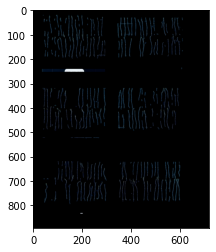

In [9]:
final_image=cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB)
plt.imshow(final_image)